# Wstęp

## Omówienie problemu

Problemem, nad którym skupię się w mojej pracy jest "problem sumy elementów podzbioru" (ang. ["subset sum problem"](https://en.wikipedia.org/wiki/Subset_sum_problem)).
Jest to problem decyzyjny, który w ogólnym założeniu polega na znalezieniu odpowiedzi na pytanie, czy dla danego zbioru liczb całkowitych $S$ istnieje podzbiór, którego wszystkie elementy sumują się dokładnie do danej liczby $T$.

W tej formie problem ten jest [NP-trudny](https://pl.wikipedia.org/wiki/Problem_NP-trudny), jednak ja skupię się na jednym z jego wariantów, który jest [NP-zupełny](https://pl.wikipedia.org/wiki/Problem_NP-zupe%C5%82ny).
Zbiór $S$, z którym będziemy pracować, będzie składał się z dodatnich i ujemnych liczb całkowitych, a szukana suma podzbioru będzie wynosiła $T=0$.

W mojej pracy postaram się znaleźć odpowiedź na zadane pytanie z wykorzystaniem dwóch rodzajów algorytmów bioinspirowanych: algorytmu genetycznego oraz inteligencji roju.


## Dane wejściowe

W celu próby rozwiązania problemu z wykorzystaniem algorytmów bioinspirowanych, przygotowałem zestaw z góry ustalonych danych wejściowych:

- 5 zbiorów liczb całkowitych z zakresu od $-100$ do $100$ liczności $100$ (dane małe)
- 5 zbiorów liczb całkowitych z zakresu od $-1000$ do $1000$ liczności $1000$ (dane średnie)
- 5 zbiorów liczb całkowitych z zakresu od $-5000$ do $5000$ liczności $5000$ (dane duże)

Dane te zostały zapisane w plikach tekstowych, odpowiednio [small_inputs.txt](small_inputs.txt), [medium_inputs.txt](medium_inputs.txt) oraz [big_inputs.txt](big_inputs.txt).
W każdej linii znajduje się jeden zbiór liczb, które są oddzielone od siebie średnikami.
Dla każdego ze zbiorów istnieje przynajmniej jeden podzbiór, który spełnia założenia rozważanego problemu (tzn. suma jego elementów jest równa $0$).

Funkcja znajdująca się poniżej służy do odczytania danych wejściowych z plików w celu dalszych obliczeń. Każda ze zmiennych `small_inputs`, `medium_inputs` oraz `big_inputs` jest słownikiem, który pod kluczami od `1` do `5` zawiera kolejne zbiory.


In [2]:
def get_inputs(inputs_file):
    result = {}
    with open(inputs_file) as inputs:
        nr = 1
        for line in inputs:
            line = line[:-1].split(";")
            result[nr] = [int(number) for number in line]
            nr += 1
    return result


small_inputs = get_inputs("small_inputs.txt")
medium_inputs = get_inputs("medium_inputs.txt")
big_inputs = get_inputs("big_inputs.txt")


## Potrzebne biblioteki

Aby przeprowadzić obliczenia, potrzebne są następujące biblioteki:


In [3]:
from pyswarms.discrete.binary import BinaryPSO
import pygad as pg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from random import randint


Biblioteki [PySwarms](https://pyswarms.readthedocs.io/en/latest/#) oraz [PyGAD](https://pygad.readthedocs.io/en/latest/) odpowiadają odpowiednio za algorytm inteligencji roju oraz algorytm genetyczny, [Matplotlib](https://matplotlib.org/) został wykorzystany do przygotowania wykresów, natomiast pozostałe są przydatne przy pracy z rozwiązaniami oraz do analizy czasu rozwiązywania problemu przez algorytmy.


# Algorytm genetyczny

Pierwszym podejściem do rozwiązania problemu będzie skorzystanie z algorytmu genetycznego, którego implementacja znajduje się w bibliotece PyGAD.
Polega on na generowaniu zbioru rozwiązań, zwanych generacją, następnie ocenianiu ich a potem tworzeniu następnej generacji na podstawie najlepszych rozwiązań, aż do momentu odnalezienia dobrego rozwiązania.


## Parametry algorytmu

W celu znalezienia efektywnego znalezienia rozwiązania przez algorytm, należy dobrać parametry odpowiednie do problemu:

- przestrzeń genów (`gene_space`): rozwiązania będą kodowane za pomocą `0` i `1`, które w kolejności oznaczają kolejne liczby zbioru $S$. `0` oznacza, że liczba ta nie powinna się znaleźć w szukanym zbiorze, a `1`, że do niego należy.
- typ wyboru rodziców (`parent_selection_type`): sposób, w jaki rodzice mają być wybieraniu spośród generacji rozwiązań, w naszym przypadku ustawiony na `sss` (ang. steady-state selection)
- typ krzyżowania (`crossover_type`): sposób, w jaki mają krzyżować się chromosomy przy rozmnażaniu, ustawiony na krzyżowanie w jednym punkcie (`single_point`)
- typ mutacji (`mutation_type`): losowy
- ilość mutowanych genów (`mutation_num_genes`): ilość genów, jaka ma być zmutowana w każdym rozwiązaniu, ustawiona na `1` gen
- kryterium zatrzymania (`stop_criteria`): wynik, po którego osiągnięciu algorytm ma się zatrzymać, jest on ustawiony na `reach_0`, czyli skończenie obliczeń przy wyniku `0` i wynika z funkcji `fitness`, która jest omówiona w dalszej części pracy

Opisane parametry są zdefiniowane poniżej:


In [4]:
gene_space = [0, 1]

parent_selection_type = "sss"
crossover_type = "single_point"
mutation_type = "random"
mutation_num_genes = 1
stop_criteria = "reach_0"


Oprócz powyższych parametrów, należy także dobrać odpowiednie wartości zależne od rozmiaru problemu (mały, średni lub duży).
Poniższa funkcja `create_ga_instance` przyjmuje następujące argumenty:

- ilość genów (`num_genes`): ilość genów, z których składa się rozwiązanie, jest równa ilości elementów danego zbioru $S$
- ilość rozwiązań w jednej generacji (`sol_per_pop`): ilość generowanych rozwiązań w trakcie jednej generacji algorytmu
- ilość rozmnażających się rodziców (`num_parents_mating`): ilość najlepszych rozwiązań, które stają się rodzicami przy rozmnażaniu
- ilośc generacji (`num_generations`): ilość generacji algorytmu
- ilość zostawionych rodziców (`keep_parents`): ilość rodziców, którzy po rozmnażaniu mają przejść do następnej generacji algorytmu

a następnie z wykorzystaniem ich oraz wcześniej zdefiniowanych parametrów inicjalizuje algorytm genetyczny i zwraca jego instancję.


In [5]:
def create_ga_instance(num_genes, sol_per_pop, num_parents_mating, num_generations, keep_parents):
    return pg.GA(
        gene_space=gene_space,
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        fitness_func=fitness_func,
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_parents=keep_parents,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_num_genes=mutation_num_genes,
        stop_criteria=stop_criteria
    )


## Funkcja `fitness`

Funkcja `fitness` jest niezbędnym elementem algorytmu genetycznego.
Jako argumenty przyjmuje ona rozwiązanie (`solution`) oraz jego indeks (`solution_idx`), i na tej podstawie oblicza jego ocenę (ang. fitness), na podstawie której potem następuje selekcja rozwiązań, a dzięki temu rozwój algorytmu.
Algorytm zdefiniowany w bibliotece PyGAD szuka maksimum, więc im wyższa ocena, tym lepsze rozwiązanie.
Dla wybranego problemu działanie poniższej funkcji `fitness_func` jest następujące:

- jako argumenty przyjmuje `solution` oraz `solution_idx`
- sprawdza, czy rozwiązanie składa się z samych `0` - jeśli tak, oznacza to że znaleziony podzbiór jest pusty, zwraca więc ocenę $-\infty$
- jeśli nie, dodaje do siebie elementy wskazanego przez rozwiązanie zbioru i zwraca ujemną wartość bezwględną tej sumy. W ten sposób coraz lepsze rozwiązania będą miały wynik coraz bardziej zbliżony do `0`, a wynik `0` będzie równoznaczny z tym, że suma elementów znalezionego zbioru jest równa `0`


In [6]:
def fitness_func(solution, solution_idx):
    if np.count_nonzero(np.array(solution) == 1) == 0:
        return -np.Inf
    else:
        res = np.sum(np.multiply(set, solution))
        return -abs(res)


Poniżej znajduje się przykład obliczenia funkcji `fitness_func` dla zbioru $S = \{-7, -3, -2, 9000, 5, 8\}$ oraz rozwiązania $[0, 1, 1, 0, 1, 0]$:


In [7]:
set = [-7, -3, -2, 9000, 5, 8]
solution = [0, 1, 1, 0, 1, 0]

fitness = fitness_func(solution, 0)

result = []
for i in range(len(solution)):
    if solution[i] == 1:
        result.append(set[i])


print("Zbiór początkowy: {}".format(set))
print("Znaleziony podzbiór: {}".format(result))
print("Suma wszystkich elementów podzbioru: {}".format(fitness))


Zbiór początkowy: [-7, -3, -2, 9000, 5, 8]
Znaleziony podzbiór: [-3, -2, 5]
Suma wszystkich elementów podzbioru: 0


Jak widać podane rozwiązanie wyznaczyło podzbiór $\{-3, -2, 5\}$, którego suma elementów jest równa $0$, tak więc ocena tego rozwiązania również jest równa $0$.


## Przeprowadzenie obliczeń

Po przygotowaniu wszystkich parametrów można przystąpić do rozwiązywania problemu. Będzie ono przebiegało następująco:

1. wybór losowego zbioru $S$ danego rozmiaru (maył, średni lub duży)
2. zmierzenie czasu przed obliczeniami
3. stworzenie instancji algorytmu z odpowiednimi dla rozmiaru problemu parametrami
4. uruchomienie algorytmu
5. zmierzenie czasu po obliczeniach
6. odczytanie i wyświetlenie rozwiązania i czasu jego znalezienia

Do wyświetlenia wyniku oraz czasu działania algorytmu posłuży poniższa funkcja pomocnicza `show_result`:


In [8]:
def show_result(time, fitness):
    print("Czas wykonania algorytmu: {} sekund".format(time))
    print("Suma elementów znalezionego podzbioru: {} => {}"
          .format(int(fitness), "znaleziono poprawne rozwiązanie" if fitness == 0 else "nie znaleziono rozwiązania"))


Wynik równy $0$ będzie oznaczał, że znaleziono dobre rozwiązanie problemu.
W poniższej tabelce znajdują się dane dla każdej wielkości algorytmu:

| Rozmiar danych wejściowych    | Małe | Średnie | Duże |
| ----------------------------- | ---- | ------- | ---- |
| Ilość genów                   | 100  | 1000    | 5000 |
| Ilość rozwiązań w populacji   | 20   | 100     | 200  |
| Ilość rodziców do rozmnażania | 10   | 50      | 100  |
| Ilość generacji               | 100  | 300     | 500  |
| Ilość zatrzymanych rodziców   | 6    | 30      | 50   |


### Dane małe


In [9]:
set = small_inputs[randint(1, 5)]

start = time()

small_instance = create_ga_instance(
    num_genes=100,
    sol_per_pop=20,
    num_parents_mating=10,
    num_generations=100,
    keep_parents=6
)

small_instance.run()

end = time()

best_solution, fitness, _ = small_instance.best_solution()

show_result(end - start, fitness)


Czas wykonania algorytmu: 0.05399370193481445 sekund
Suma elementów znalezionego podzbioru: 0 => znaleziono poprawne rozwiązanie


Algorytm znalazł poprawne rozwiązanie w bardzo szybkim czasie ($<0.055s$).


In [10]:
set = medium_inputs[randint(1, 5)]

start = time()

medium_instance = create_ga_instance(
    num_genes=1000,
    sol_per_pop=100,
    num_parents_mating=50,
    num_generations=300,
    keep_parents=30
)

medium_instance.run()

end = time()

best_solution, fitness, _ = medium_instance.best_solution()

show_result(end - start, fitness)


Czas wykonania algorytmu: 0.23917818069458008 sekund
Suma elementów znalezionego podzbioru: 0 => znaleziono poprawne rozwiązanie


### Dane duże


In [11]:
set = big_inputs[randint(1, 5)]

start = time()

big_instance = create_ga_instance(
    num_genes=5000,
    sol_per_pop=200,
    num_parents_mating=100,
    num_generations=500,
    keep_parents=50
)

big_instance.run()

end = time()

best_solution, fitness, _ = big_instance.best_solution()

show_result(end - start, fitness)


Czas wykonania algorytmu: 29.200138568878174 sekund
Suma elementów znalezionego podzbioru: 0 => znaleziono poprawne rozwiązanie


In [12]:
ga_times = pd.read_csv("ga_times.csv")


def ga_data(input):
    column = ga_times[ga_times[input] != 0][input]
    result = {"column": column}
    result["avg_time"] = column.mean()
    result["accuraccy"] = len(column) / 100
    result["min_time"] = column.min()
    result["max_time"] = column.max()
    return result


def plot_times(data, algotihm):
    plt.figure(figsize=(12, 5))
    plt.suptitle("Czas znalezienia rozwiązania przez {}".format(algotihm))
    for i in range(3):
        plt.subplot(1, 3, i+1)
        if i == 0:
            plt.title("Małe dane")
        elif i == 1:
            plt.title("Średnie dane")
        else:
            plt.title("Duże dane")
        plt.xlabel("Numer udanego pomiaru")
        plt.ylabel("Czas [s]")
        curr_data = data[i]
        x = np.linspace(0, len(curr_data["column"]), len(curr_data["column"]))
        plt.plot(x, curr_data["column"], marker="o")
        plt.plot(x, [curr_data["avg_time"] for _ in x], linewidth=3)

    plt.figlegend(labels=["Czas działania", "Średnia"], loc="upper left")
    plt.tight_layout()
    plt.show()


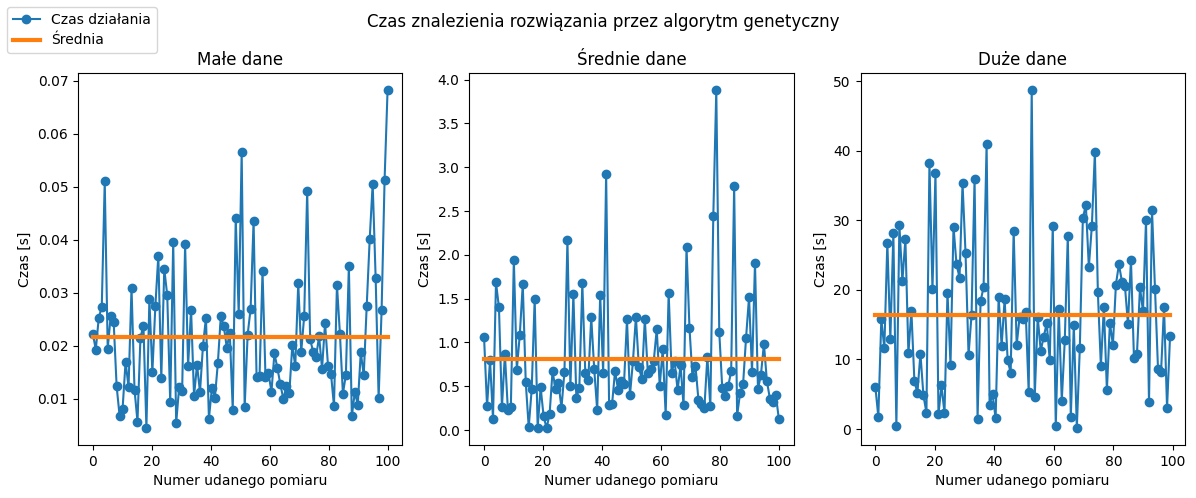

In [13]:
data = [ga_data("small_input"),
        ga_data("medium_input"),
        ga_data("big_input")]

plot_times(data, "algorytm genetyczny")


| Rozmiar danych wejściowych |         Małe          |       Średnie       |        Duże         |
| :------------------------: | :-------------------: | :-----------------: | :-----------------: |
|   Skuteczność algorytmu    |         100%          |        100%         |         99%         |
|    Najszybsze wykonanie    |   0.00447678565979s   | 0.0252683162689209s | 0.1766080856323242s |
|    Najdłuższe wykonanie    |  0.0682284832000732s  | 3.8786752223968506s | 48.67165207862854s  |
|   Średni czas wykonania    | 0.021550991535186723s | 0.8110143566131591s | 16.343913774297693s |


# Inteligencja roju


In [14]:
def optimizer_function(x):
    n_particles = x.shape[0]
    j = [-fitness_func(x[i], _) for i in range(n_particles)]
    return np.array(j)


In [15]:
options = {
    'c1': 0.5,
    'c2': 0.3,
    'w': 0.9,
    'k': 10,
    'p': 1
}


In [16]:
set = small_inputs[randint(1, 5)]

start = time()

optimizer = BinaryPSO(n_particles=10, dimensions=len(set), options=options)

cost, pos = optimizer.optimize(optimizer_function, iters=500, verbose=False)

end = time()

show_result(end - start, cost)


Czas wykonania algorytmu: 0.15477561950683594 sekund
Suma elementów znalezionego podzbioru: 0 => znaleziono poprawne rozwiązanie


In [17]:
set = medium_inputs[randint(1, 5)]

options['k'] = 30

start = time()

optimizer = BinaryPSO(n_particles=30, dimensions=len(set), options=options)

cost, pos = optimizer.optimize(optimizer_function, iters=1250, verbose=False)

end = time()

show_result(end - start, cost)


Czas wykonania algorytmu: 5.184582710266113 sekund
Suma elementów znalezionego podzbioru: 0 => znaleziono poprawne rozwiązanie


In [18]:
set = big_inputs[randint(1, 5)]

options['k'] = 50

start = time()

optimizer = BinaryPSO(n_particles=50, dimensions=len(set), options=options)

cost, pos = optimizer.optimize(optimizer_function, iters=1250, verbose=False)

end = time()

show_result(end - start, cost)


Czas wykonania algorytmu: 46.970276832580566 sekund
Suma elementów znalezionego podzbioru: 0 => znaleziono poprawne rozwiązanie


In [19]:
pso_times = pd.read_csv("pso_times.csv")


def pso_data(input):
    column = pso_times[pso_times[input] != 0][input]
    result = {"column": column}
    result["avg_time"] = column.mean()
    result["accuraccy"] = len(column) / 100
    result["min_time"] = column.min()
    result["max_time"] = column.max()
    return result


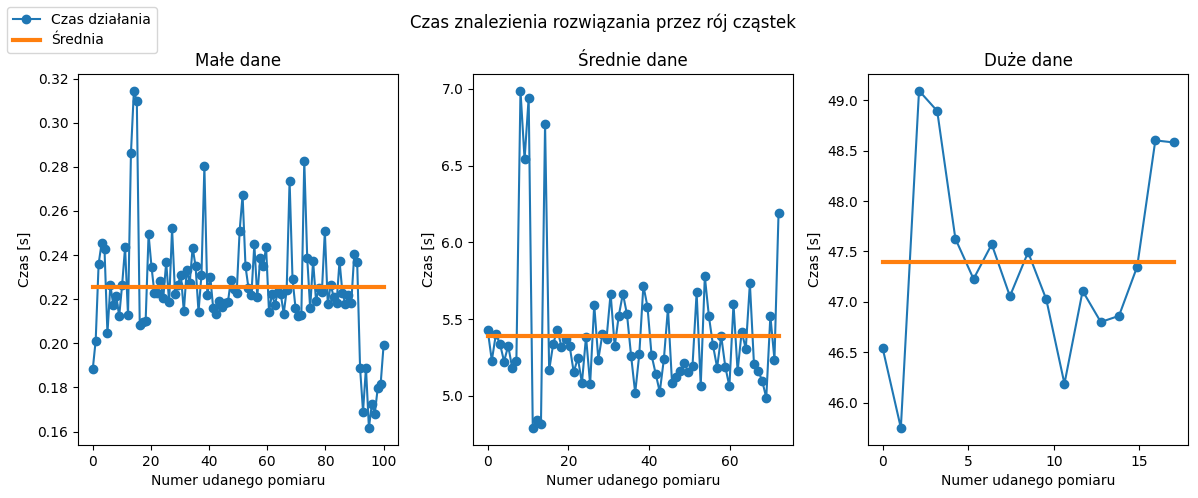

In [20]:
data = [pso_data("small_input"),
        pso_data("medium_input"),
        pso_data("big_input")]

plot_times(data, "rój cząstek")


| Rozmiar danych wejściowych |         Małe         |      Średnie       |        Duże         |
| :------------------------: | :------------------: | :----------------: | :-----------------: |
|   Skuteczność algorytmu    |         100%         |        72%         |         17%         |
|    Najszybsze wykonanie    | 0.1616637706756591s  | 4.791399717330933s |  45.748215675354s   |
|    Najdłuższe wykonanie    | 0.3144810199737549s  | 6.987470388412476s | 49.09682369232178s  |
|   Średni czas wykonania    | 0.22535311222076415s | 5.390086862776014s | 47.398172673057104s |
